This notebook is for reproducing all results reported in paper "Conversations Gone Awry, But Then? Evaluating Conversational Forecasting Models".
The results include:
1. Performance of TransformerEncoderModels (BERT-base, BERT-large, RoBERTa-base, RoBERTa-large, SpanBERT-base, SpanBERT-large, DeBERTaV3-base, and DeBERTaV3-large)
2. Performance of TransformerDecoderModels (Gemma2 9B, LlaMA3.1 8B, Mistral 7B, and Phi4 14B)

In [3]:
from convokit import (download,
                      Corpus,
                      Forecaster,
                      TransformerEncoderModel,
                      TransformerDecoderModel,
                      TransformerForecasterConfig,
)
import tarfile
import json, os, shutil
import re
import urllib.request
from urllib.parse import urljoin, urlparse

/reef/conda-envs/sqt-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sqt2/ConvoKit/convokit/forecaster/TransformerDecoderModel.py:1: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel, is_bfloat16_supported


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


### Define datasets and working directories 

In [4]:
# CPU mode (noting that it will be slower)
DEVICE = "cuda"

corpus_name = "cga-wikiconv"
# corpus_name = "cga-cmv-legacy"
# corpus_name = "cga-cmv-large"
label_metadata = "has_removed_comment" if 'cmv' in corpus_name else 'conversation_has_personal_attack'

YOUR_MODEL_DIRECTORY = "YOUR_MODEL_DIRECTORY"
YOUR_SAVING_DIRECTORY = "YOUR_SAVING_DIRECTORY"

In [5]:
if corpus_name == "cga-wikiconv":
    corpus = Corpus(filename=download("conversations-gone-awry-corpus"))
elif corpus_name == "cga-cmv-legacy":
    corpus = Corpus(filename=download("conversations-gone-awry-cmv-corpus"))
elif corpus_name == "cga-cmv-large":
    raise ValueError(f"The corpus {corpus_name} has not been published. This corpus is not available.")

Dataset already exists at /home/sqt2/.convokit/saved-corpora/conversations-gone-awry-corpus


### Download Fine-tuned Models

In [ ]:
MODEL = "bert-base-cased"

**List of Models**

**TransformerEncoderModel**
- `bert-base-cased` — BERT-base  
- `roberta-base` — RoBERTa-base  
- `SpanBERT/spanbert-base-cased` — SpanBERT-base  
- `microsoft/deberta-v3-base` — DeBERTaV3-base  
- `bert-large-cased` — BERT-large  
- `roberta-large` — RoBERTa-large  
- `SpanBERT/spanbert-large-cased` — SpanBERT-large  
- `microsoft/deberta-v3-large` — DeBERTaV3-large  

**TransformerDecoderModel**
- `google/gemma-2-9b-it` — Gemma2 9B  
- `meta-llama/Llama-3.1-8B-Instruct` — LLaMA 3.1 8B  
- `mistralai/Mistral-7B-Instruct-v0.3` — Mistral 7B  
- `microsoft/phi-4` — Phi-4 14B

In [7]:
BASE_URL = f"https://zissou.infosci.cornell.edu/convokit/models/forecaster_models/{corpus_name}/{MODEL}/"
DOWNLOAD_DIR = f"{YOUR_MODEL_DIRECTORY}/{corpus_name}/{MODEL}"

def is_directory(href):
    return href.endswith('/')

def list_links(url):
    """List files and directories from an Apache-style directory listing."""
    response = urllib.request.urlopen(url)
    html = response.read().decode('utf-8')
    return re.findall(r'href="([^"?][^"]*)"', html)

def download_file(file_url, dest_path):
    if os.path.exists(dest_path):
        print(f"Skipped existing: {dest_path}")
        return
    urllib.request.urlretrieve(file_url, dest_path)

def download_recursive(base_url, base_folder):
    links = list_links(base_url)
    for href in links:
        if href in ('../',):  # skip parent link
            continue
        full_url = urljoin(base_url, href)
        parsed = urlparse(full_url)
        relative_path = parsed.path.replace(urlparse(BASE_URL).path, '').lstrip('/')
        local_path = os.path.join(base_folder, relative_path)

        if is_directory(href):
            os.makedirs(local_path, exist_ok=True)
            download_recursive(full_url, base_folder)
        else:
            os.makedirs(os.path.dirname(local_path), exist_ok=True)
            download_file(full_url, local_path)

os.makedirs(DOWNLOAD_DIR, exist_ok=True)
download_recursive(BASE_URL, DOWNLOAD_DIR)
forecasting_models_path = DOWNLOAD_DIR

## Define selectors for the Forecaster

Core to the flexibility of the `Forecaster` framework is the concept of *selectors*. 

To capture the temporal dimension of the conversational forecasting task, `Forecaster` iterates through conversations in chronological utterance order, at each step presenting to the backend forecasting model a "context tuple" containing both the comment itself and the full "context" preceding that comment. As a general framework, `Forecaster` on its own does not try to make any further assumptions about what "context" should contain or look like; it simply presents context as a chronologically ordered list of all utterances up to and including the current one. 

In [8]:

def transform_selector(context_tuple):
    """
    For transform we only need to check that the conversation is in the test split
    """
    convo = context_tuple.current_utterance.get_conversation()
    convo_length = len(convo.get_chronological_utterance_list())

    matches_split = (context_tuple.current_utterance.get_conversation().meta["split"] == "test")
    is_end = (len(context_tuple.context) == convo_length)

    return (matches_split and not is_end)
def update_metrics(all_results, cur_metrics):
    for metric in cur_metrics:
        all_results[metric] = all_results.get(metric, []) + [cur_metrics[metric]]
    return all_results

# Transformer Encoder-based Forecaster

Evaluating Random Seed 1


100%|██████████| 5131/5131 [00:47<00:00, 109.11it/s]


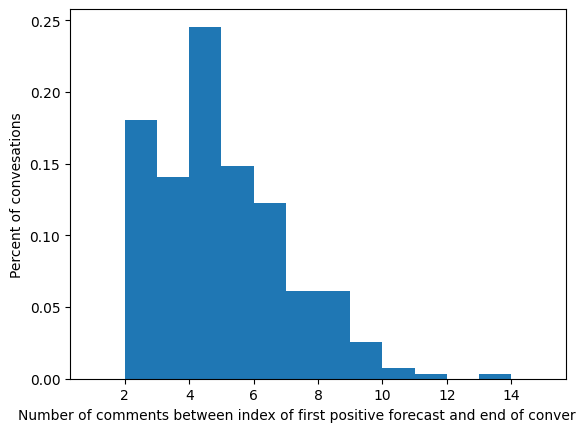

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 3.5899280575539567, Median = 3.0
Accuracy                                                         0.661905
Precision                                                        0.661905
Recall                                                           0.661905
FPR                                                              0.338095
F1                                                               0.661905
Mean H                                                           3.589928
Correct Adjustment                                                   0.05
Incorrect Adjustment                                             0.066667
Recovery                                                        -0.016667
Leaderboard String      | MODEL_NAME     | 66.2   | 66.2  | 66.2 | 66....
dtype: object
Evaluating Random Seed 2


100%|██████████| 5131/5131 [00:47<00:00, 108.70it/s]


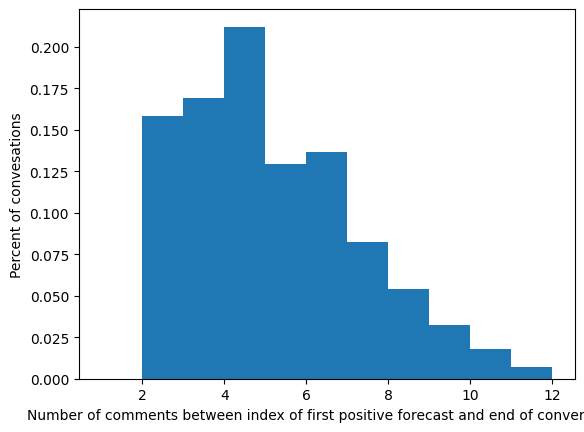

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 3.731182795698925, Median = 3.0
Accuracy                                                         0.666667
Precision                                                        0.667464
Recall                                                           0.664286
FPR                                                              0.330952
F1                                                               0.665871
Mean H                                                           3.731183
Correct Adjustment                                               0.054762
Incorrect Adjustment                                              0.07619
Recovery                                                        -0.021429
Leaderboard String      | MODEL_NAME     | 66.7   | 66.7  | 66.4 | 66....
dtype: object
Evaluating Random Seed 3


100%|██████████| 5131/5131 [00:47<00:00, 109.03it/s]


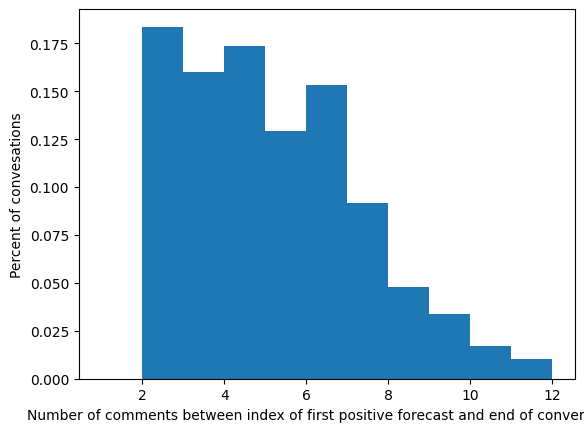

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 3.7491525423728813, Median = 3.0
Accuracy                                                         0.672619
Precision                                                        0.662921
Recall                                                           0.702381
FPR                                                              0.357143
F1                                                               0.682081
Mean H                                                           3.749153
Correct Adjustment                                               0.070238
Incorrect Adjustment                                             0.088095
Recovery                                                        -0.017857
Leaderboard String      | MODEL_NAME     | 67.3   | 66.3  | 70.2 | 68....
dtype: object
Evaluating Random Seed 4


100%|██████████| 5131/5131 [00:47<00:00, 108.49it/s]


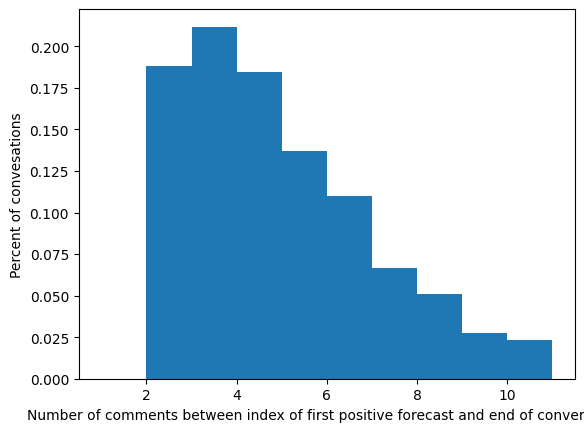

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 3.484375, Median = 3.0
Accuracy                                                         0.642857
Precision                                                        0.653061
Recall                                                           0.609524
FPR                                                               0.32381
F1                                                               0.630542
Mean H                                                           3.484375
Correct Adjustment                                               0.055952
Incorrect Adjustment                                             0.060714
Recovery                                                        -0.004762
Leaderboard String      | MODEL_NAME     | 64.3   | 65.3  | 61.0 | 63....
dtype: object
Evaluating Random Seed 5


100%|██████████| 5131/5131 [00:47<00:00, 108.92it/s]


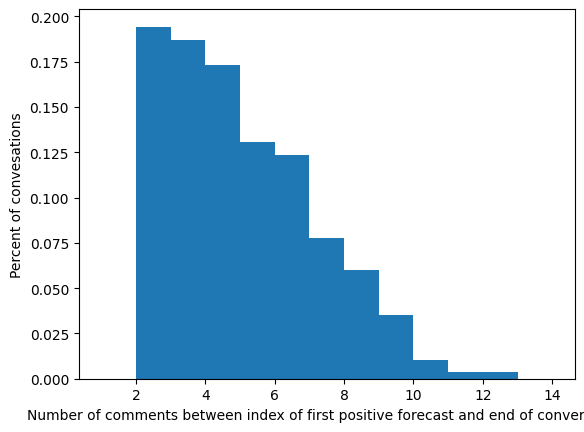

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 3.605633802816901, Median = 3.0
Accuracy                                                         0.678571
Precision                                                        0.679426
Recall                                                            0.67619
FPR                                                              0.319048
F1                                                               0.677804
Mean H                                                           3.605634
Correct Adjustment                                                   0.05
Incorrect Adjustment                                             0.070238
Recovery                                                        -0.020238
Leaderboard String      | MODEL_NAME     | 67.9   | 67.9  | 67.6 | 67....
dtype: object
{'Accuracy': np.float64(0.6645238095238095), 'Precision': np.float64(0.6649554573724549), 'Recall': np.float64(0.66285

In [10]:
all_results = {}
for seed in range(1,6):
    print(f"Evaluating Random Seed {seed}")
    config_dict = TransformerForecasterConfig(
        output_dir=f"{YOUR_SAVING_DIRECTORY}/{corpus_name}/{MODEL}/seed{seed}",
        context_mode="normal", # set to normal by default
        device=DEVICE
    )
    saved_model_path = os.path.join(forecasting_models_path, f'seed-{seed}')

    #Load pre-tuned config
    tuned_config_file = os.path.join(saved_model_path, "dev_config.json")
    with open(tuned_config_file, 'r') as file:
        tuned_config = json.load(file)

    encoder_model = TransformerEncoderModel(os.path.join(saved_model_path, tuned_config['best_checkpoint']), config=config_dict)
    encoder_model.best_threshold = tuned_config['best_threshold']
    encoder_forecaster = Forecaster(encoder_model, label_metadata)

    # corpus = copy.deepcopy(corpus)
    corpus = encoder_forecaster.transform(corpus, transform_selector)
    _, cur_metrics= encoder_forecaster.summarize(corpus, lambda c: c.meta['split'] == "test")

    update_metrics(all_results, cur_metrics)

for metric in all_results:
    if metric == "Leaderboard String":
        continue
    all_results[metric] = sum(all_results[metric]) / len(all_results[metric])

print(all_results)

In [11]:
leaderboard_string = (f"| BERT-base     | "
                              f"{all_results['Accuracy']*100:.1f}   | "
                              f"{all_results['Precision']*100:.1f}  | "
                              f"{all_results['Recall']*100:.1f} | "
                              f"{all_results['F1']*100:.1f}  | "
                              f"{all_results['FPR']*100:.1f}   | "
                              f"{all_results['Mean H']:.2f} | "
                              f"{(all_results['Correct Adjustment']-all_results['Incorrect Adjustment'])*100:.1f} "
                              f"({all_results['Correct Adjustment']*100:.1f} - {all_results['Incorrect Adjustment']*100:.1f})  |")
all_results['Leaderboard String'] = leaderboard_string
print(json.dumps(all_results, indent=4))


{
    "Accuracy": 0.6645238095238095,
    "Precision": 0.6649554573724549,
    "Recall": 0.6628571428571428,
    "FPR": 0.33380952380952383,
    "F1": 0.6636405952685067,
    "Mean H": 3.6320544396885324,
    "Correct Adjustment": 0.05619047619047619,
    "Incorrect Adjustment": 0.07238095238095239,
    "Recovery": -0.016190476190476193,
    "Leaderboard String": "| BERT-base     | 66.5   | 66.5  | 66.3 | 66.4  | 33.4   | 3.63 | -1.6 (5.6 - 7.2)  |"
}


# Transformer Decoder-based Forecaster

In [12]:
MODEL = "google/gemma-2-9b-it"
BASE_URL = f"https://zissou.infosci.cornell.edu/convokit/models/forecaster_models/{corpus_name}/{MODEL}/"
DOWNLOAD_DIR = f"{YOUR_MODEL_DIRECTORY}/{corpus_name}/{MODEL}"

os.makedirs(DOWNLOAD_DIR, exist_ok=True)
download_recursive(BASE_URL, DOWNLOAD_DIR)
forecasting_models_path = DOWNLOAD_DIR

Evaluating Random Seed 1
==((====))==  Unsloth 2025.3.19: Fast Gemma2 patching. Transformers: 4.50.3.
   \\   /|    NVIDIA RTX A6000. Num GPUs = 1. Max memory: 47.536 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.3.19 patched 42 layers with 42 QKV layers, 42 O layers and 42 MLP layers.
Unsloth: Will map <end_of_turn> to EOS = <end_of_turn>.
0it [00:00, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
5131it [15:38,  5.47it/s]


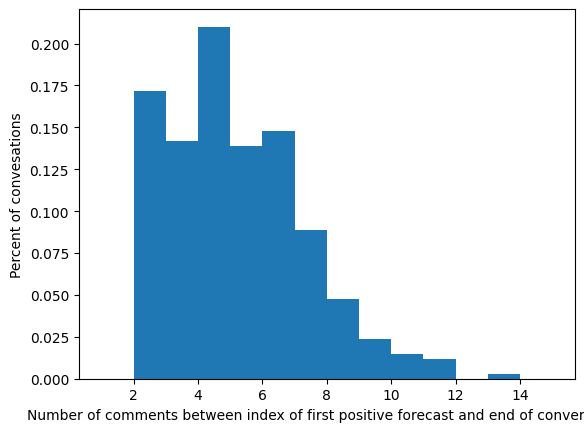

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 3.7551622418879056, Median = 3.0
Accuracy                                                         0.688095
Precision                                                        0.651923
Recall                                                           0.807143
FPR                                                              0.430952
F1                                                               0.721277
Mean H                                                           3.755162
Correct Adjustment                                               0.045238
Incorrect Adjustment                                             0.030952
Recovery                                                         0.014286
Leaderboard String      | MODEL_NAME     | 68.8   | 65.2  | 80.7 | 72....
dtype: object
Evaluating Random Seed 2
==((====))==  Unsloth 2025.3.19: Fast Gemma2 patching. Transformers: 4.50.3.
   \\   /|    N

5131it [15:34,  5.49it/s]


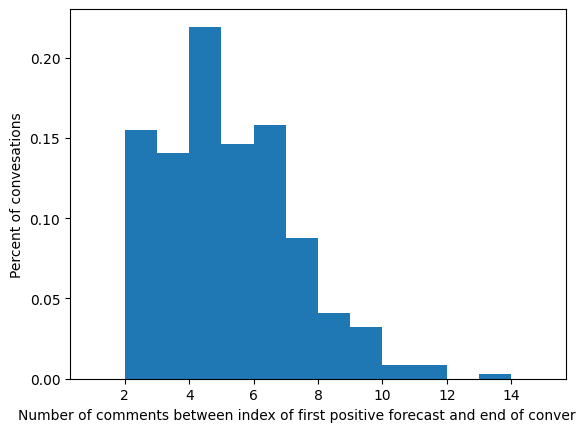

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 3.7725947521865892, Median = 3.0
Accuracy                                                          0.67381
Precision                                                        0.635185
Recall                                                           0.816667
FPR                                                              0.469048
F1                                                               0.714583
Mean H                                                           3.772595
Correct Adjustment                                               0.035714
Incorrect Adjustment                                             0.021429
Recovery                                                         0.014286
Leaderboard String      | MODEL_NAME     | 67.4   | 63.5  | 81.7 | 71....
dtype: object
Evaluating Random Seed 3
==((====))==  Unsloth 2025.3.19: Fast Gemma2 patching. Transformers: 4.50.3.
   \\   /|    N

5131it [15:35,  5.49it/s]


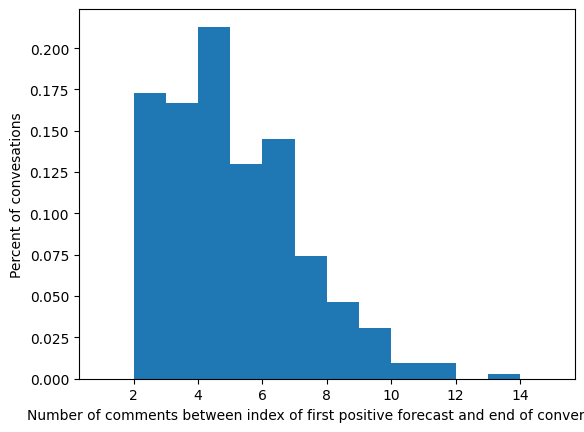

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 3.6523076923076925, Median = 3.0
Accuracy                                                         0.692857
Precision                                                        0.665984
Recall                                                            0.77381
FPR                                                              0.388095
F1                                                               0.715859
Mean H                                                           3.652308
Correct Adjustment                                                0.04881
Incorrect Adjustment                                             0.032143
Recovery                                                         0.016667
Leaderboard String      | MODEL_NAME     | 69.3   | 66.6  | 77.4 | 71....
dtype: object
Evaluating Random Seed 4
==((====))==  Unsloth 2025.3.19: Fast Gemma2 patching. Transformers: 4.50.3.
   \\   /|    N

5131it [15:39,  5.46it/s]


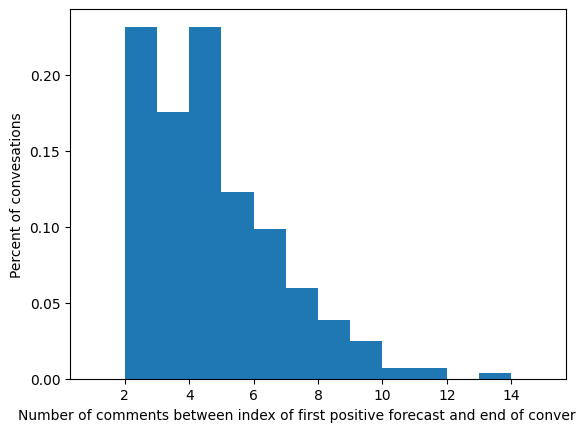

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 3.300699300699301, Median = 3.0
Accuracy                                                         0.704762
Precision                                                           0.715
Recall                                                           0.680952
FPR                                                              0.271429
F1                                                               0.697561
Mean H                                                           3.300699
Correct Adjustment                                               0.035714
Incorrect Adjustment                                             0.038095
Recovery                                                        -0.002381
Leaderboard String      | MODEL_NAME     | 70.5   | 71.5  | 68.1 | 69....
dtype: object
Evaluating Random Seed 5
==((====))==  Unsloth 2025.3.19: Fast Gemma2 patching. Transformers: 4.50.3.
   \\   /|    NV

5131it [15:40,  5.45it/s]


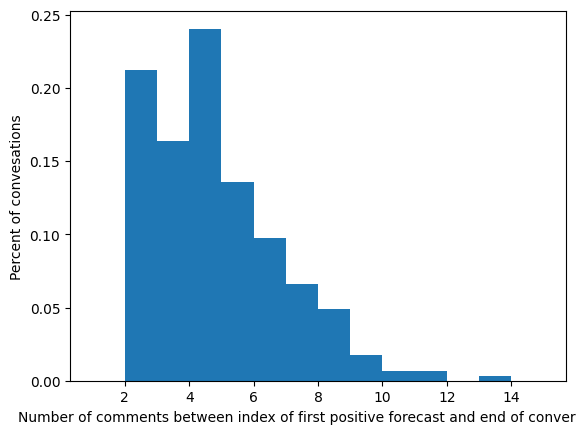

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 3.385416666666667, Median = 3.0
Accuracy                                                          0.70119
Precision                                                        0.707617
Recall                                                           0.685714
FPR                                                              0.283333
F1                                                               0.696493
Mean H                                                           3.385417
Correct Adjustment                                               0.039286
Incorrect Adjustment                                             0.038095
Recovery                                                          0.00119
Leaderboard String      | MODEL_NAME     | 70.1   | 70.8  | 68.6 | 69....
dtype: object


In [13]:
# This cell takes around 80 mins on a single NVIDIA RTX A6000
all_results = {}
for seed in range(1,6):
    print(f"Evaluating Random Seed {seed}")
    config_dict = TransformerForecasterConfig(
        output_dir=f"{YOUR_SAVING_DIRECTORY}/{corpus_name}/{MODEL}/seed{seed}",
        context_mode="normal", # set to normal by default
        device=DEVICE
    )
    saved_model_path = os.path.join(forecasting_models_path, f'seed-{seed}')

    #Load pre-tuned config
    tuned_config_file = os.path.join(saved_model_path, "dev_config.json")
    with open(tuned_config_file, 'r') as file:
        tuned_config = json.load(file)

    decoder_model = TransformerDecoderModel(os.path.join(saved_model_path, tuned_config['best_checkpoint']), config=config_dict)
    decoder_model.best_threshold = tuned_config['best_threshold']
    decoder_forecaster = Forecaster(decoder_model, label_metadata)

    # corpus = copy.deepcopy(corpus)
    corpus = decoder_forecaster.transform(corpus, transform_selector)
    _, cur_metrics= decoder_forecaster.summarize(corpus, lambda c: c.meta['split'] == "test")

    update_metrics(all_results, cur_metrics)

for metric in all_results:
    if metric == "Leaderboard String":
        continue
    all_results[metric] = sum(all_results[metric]) / len(all_results[metric])


In [14]:
leaderboard_string = (f"| Gemma2-9B     | "
                              f"{all_results['Accuracy']*100:.1f}   | "
                              f"{all_results['Precision']*100:.1f}  | "
                              f"{all_results['Recall']*100:.1f} | "
                              f"{all_results['F1']*100:.1f}  | "
                              f"{all_results['FPR']*100:.1f}   | "
                              f"{all_results['Mean H']:.2f} | "
                              f"{(all_results['Correct Adjustment']-all_results['Incorrect Adjustment'])*100:.1f} "
                              f"({all_results['Correct Adjustment']*100:.1f} - {all_results['Incorrect Adjustment']*100:.1f})  |")
all_results['Leaderboard String'] = leaderboard_string
print(json.dumps(all_results, indent=4))

{
    "Accuracy": 0.6921428571428571,
    "Precision": 0.6751417152564694,
    "Recall": 0.7528571428571429,
    "FPR": 0.3685714285714286,
    "F1": 0.7091546569961278,
    "Mean H": 3.573236130749631,
    "Correct Adjustment": 0.04095238095238095,
    "Incorrect Adjustment": 0.03214285714285715,
    "Recovery": 0.008809523809523807,
    "Leaderboard String": "| Gemma2-9B     | 69.2   | 67.5  | 75.3 | 70.9  | 36.9   | 3.57 | 0.9 (4.1 - 3.2)  |"
}
